# Part 3. Data Serving. Long Short-Term Memory

### Load the parquet files

In [1]:
from pyspark.sql import SparkSession
import sys
from pyspark.sql import functions as F

# Create a SparkSession with the best configuration we tested
spark = (
    SparkSession.builder
    .appName("Data_serving_LSTM")
    .config("spark.executor.extraPythonPackages", "spark_tensorflow_distributor,tensorflow")
    .config("spark.driver.extraPythonPackages", "spark_tensorflow_distributor,tensorflow")
    .config("spark.executorEnv.PYTHONPATH", ":".join(sys.path))
    .config("spark.master", "yarn")
    .config("spark.driver.memory", "4g")
    .config("spark.yarn.am.memory", "2g")
    .config("spark.executor.memory", "4g")
    .config("spark.executor.cores", "4")
    .config("spark.executor.instances", "3")
    .config("spark.task.cpus", "2")
    .config("spark.dynamicAllocation.enabled", "false")
    .getOrCreate()
)

#Under development we set the log level to INFO to see error messages during training
#spark.sparkContext.setLogLevel("INFO")

df = spark.read.parquet("hdfs:///project/cleaned_data_parquet")

df.show()

+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|
|2000-01-20|          4|    0.34|    0.94|
+----------

# Split the data into training (0.6), validation (0.2) and test (0.2) sets sequentially

In [2]:
from pyspark.sql import functions as F

total_count = df.count()

train_size = int(total_count * 0.6)
val_size = int(total_count * 0.2)
test_size = int(total_count * 0.2)

train_df = df.limit(train_size).orderBy(F.col('date').asc())
val_df = df.limit(train_size + val_size).subtract(train_df).orderBy(F.col('date').asc())
test_df = df.subtract(train_df).subtract(val_df).orderBy(F.col('date').asc())

# Show sizes of the splits
print(f"Train size: {train_df.count()}")
print(f"Validation size: {val_df.count()}")
print(f"Test size: {test_df.count()}")  


train_df.show()
#Print one row of the dataframe
print(train_df.first())


Train size: 5431
Validation size: 1810
Test size: 1811
+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|

Row(date='2000-01-01', temperature=-6, feature1=0.019999999552965164, feature2=1.0)


### Create sequences with 90 days of historical data as input and 30 days as target values shifted by 1 day sequence.

**Features:** temp, sine and cosine

**Target:** temp

In [3]:
from pyspark.sql import DataFrame
from datetime import datetime
import numpy as np

def create_sequences(df, input_length=90, output_length=30):
    sequences = []
    targets = []
    date_input = []
    date_output = []
    
    data = df.collect()

    for i in range(len(data) - input_length - output_length + 1):
        sequence = [[data[j][1], round(data[j][2], 2), round(data[j][3], 2)] for j in range(i, i + input_length)]
        sequences.append(sequence)
        date = [[datetime.strptime(data[j][0], '%Y-%m-%d')] for j in range(i, i + input_length)]
        date_input.append(date)
        
        target = [data[i + input_length + j][1] for j in range(output_length)] 
        targets.append(target)
        date = [datetime.strptime(data[i + input_length + j][0], '%Y-%m-%d') for j in range(output_length)]
        date_output.append(date)
        
    date_input = np.array(date_input)
    date_output = np.array(date_output)
    
    return sequences, targets, date_input, date_output

x_train, y_train, train_date_input, train_date_output = create_sequences(train_df)

x_val, y_val, val_date_input, val_date_output = create_sequences(val_df)

x_test, y_test, test_date_input, test_date_output = create_sequences(test_df)

print(x_train[-1])
print(y_train[-1])

[[20, -0.3, -0.95], [21, -0.31, -0.95], [22, -0.33, -0.94], [24, -0.35, -0.94], [24, -0.36, -0.93], [23, -0.38, -0.93], [24, -0.39, -0.92], [24, -0.41, -0.91], [19, -0.43, -0.91], [20, -0.44, -0.9], [21, -0.46, -0.89], [19, -0.47, -0.88], [18, -0.49, -0.87], [18, -0.5, -0.87], [18, -0.52, -0.86], [18, -0.53, -0.85], [19, -0.55, -0.84], [17, -0.56, -0.83], [18, -0.57, -0.82], [18, -0.59, -0.81], [19, -0.6, -0.8], [17, -0.62, -0.79], [16, -0.63, -0.78], [15, -0.64, -0.77], [14, -0.66, -0.76], [13, -0.67, -0.74], [13, -0.68, -0.73], [15, -0.69, -0.72], [15, -0.71, -0.71], [13, -0.72, -0.7], [12, -0.73, -0.68], [13, -0.74, -0.67], [13, -0.75, -0.66], [14, -0.76, -0.65], [12, -0.77, -0.63], [12, -0.79, -0.62], [12, -0.8, -0.61], [13, -0.81, -0.59], [14, -0.82, -0.58], [16, -0.83, -0.56], [15, -0.84, -0.55], [14, -0.85, -0.53], [12, -0.85, -0.52], [12, -0.86, -0.5], [12, -0.87, -0.49], [15, -0.88, -0.47], [15, -0.89, -0.46], [15, -0.9, -0.44], [14, -0.9, -0.43], [14, -0.91, -0.41], [15, -0.9

### Model configuration and training

Source: https://github.com/tensorflow/ecosystem/tree/master/spark/spark-tensorflow-distributor

In [4]:
from spark_tensorflow_distributor import MirroredStrategyRunner
import tensorflow as tf

def train():
    BATCH_SIZE = 64
    EPOCHS = 200

    def make_datasets():
        global x_train, y_train, x_val, y_val
        
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
        
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        train_dataset = train_dataset.with_options(options)
        val_dataset = val_dataset.with_options(options)
        
        return train_dataset, val_dataset

    def make_test_dataset():
        global x_test, y_test
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
        return test_dataset

    # https://medium.com/@sebastienwebdev/forecasting-weather-patterns-with-lstm-a-python-guide-without-dates-433f0356136c
    def build_and_compile_lstm_model():
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(90, 3)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(30)
        ])
        # Using learning rate of 0.01 since it was the best learning rate we found
        model.compile(
            loss="mean_squared_error",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        )
        return model

    # Load datasets
    train_datasets, val_datasets = make_datasets()
    test_datasets = make_test_dataset()

    # Build model
    model = build_and_compile_lstm_model()
    
    # Early stopping callback to prevent overfitting
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,
        restore_best_weights=True
    )
    
    # Train model
    model.fit(
        x=train_datasets, 
        epochs=EPOCHS, 
        verbose=1,
        validation_data=val_datasets,
        callbacks=[early_stopping_cb]
    )

    # Evaluate and calculate metrics
    y_pred = model.predict(test_datasets)
    
    return {
        "y_pred": y_pred
    }
    
# Run distributed training
runner = MirroredStrategyRunner(num_slots=3, use_gpu=False)
metrics_results = runner.run(train)
predictions = np.array(metrics_results["y_pred"])
y_test = np.array(y_test)


2024-11-25 13:09:38.186726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 13:09:38.233795: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 13:09:38.234404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 13:09:38.920679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Doing CPU training...
Will run with 3 Spark tasks.
Distributed training in progress...
View Spark executor stderr logs to inspect training...
Training with 3 slots is complete!                                              


### Function to calculate metrics and plot predictions

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics_and_plot(predicted_values, actual_values, date, index, margin_error=1, model_type="LSTM"):
    index = index - 1
    mae = mean_absolute_error(actual_values[:, index], predicted_values[:, index])
    mse = mean_squared_error(actual_values[:, index], predicted_values[:, index])
    rmse = np.sqrt(mse)
    
    residuals = actual_values[:, index] - predicted_values[:, index]
    
    std_residuals = np.std(residuals)
    
    z_score = 1.96  
    prediction_intervals = z_score * std_residuals
    
    lower_bound = predicted_values[:, index] - prediction_intervals
    upper_bound = predicted_values[:, index] + prediction_intervals

    within_confidence_interval = np.logical_and(
        actual_values[:, index] >= lower_bound,
        actual_values[:, index] <= upper_bound
    )
    percentage_within_interval = np.mean(within_confidence_interval) * 100

    abs_diff = np.abs(actual_values[:, index] - predicted_values[:, index])

    within_margin_error = abs_diff <= margin_error

    percentage_within_margin = np.mean(within_margin_error) * 100
    
    plt.figure(figsize=(12, 6))
    plt.plot(date[:, index], actual_values[:, index], label="True values")
    plt.plot(date[:, index], predictions[:, index], label="Predictions")
    plt.fill_between(date[:, index], lower_bound, upper_bound, color='gray', alpha=0.2, label="95% Confidence Interval")
    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.title(f"{model_type} {index+1} day prediction: True values vs predictions")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    
    return mae, mse, rmse, percentage_within_interval, percentage_within_margin


# 1 Day prediction

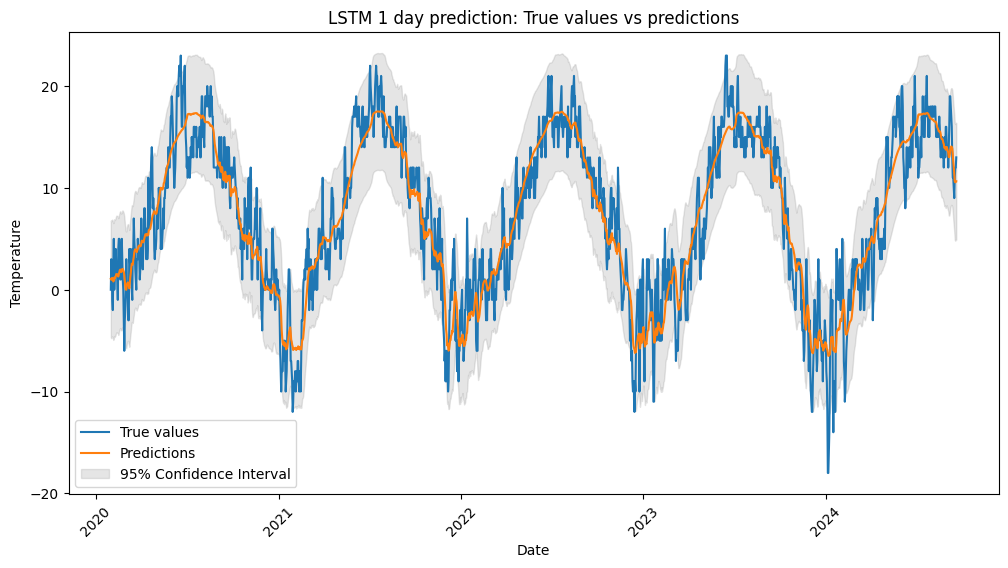

LSTM 1 day MAE: 2.3157138085833817
LSTM 1 day MSE: 8.583837235635556
LSTM 1 day RMSE: 2.929818635280272
LSTM 1 day percentage within confidence interval: 94.8581560283688%
LSTM 1 day percentage within margin of error: 27.482269503546096%


In [6]:
lstm_1day_mae, lstm_1day_mse, lstm_1day_rmse, lstm_one_day_within_interval, lstm_one_day_within_margin = calculate_metrics_and_plot(predictions, y_test, test_date_output, 1)
print(f"LSTM 1 day MAE: {lstm_1day_mae}")
print(f"LSTM 1 day MSE: {lstm_1day_mse}")
print(f"LSTM 1 day RMSE: {lstm_1day_rmse}")
print(f"LSTM 1 day percentage within confidence interval: {lstm_one_day_within_interval}%")
print(f"LSTM 1 day percentage within margin of error: {lstm_one_day_within_margin}%")

# 7 Day prediction

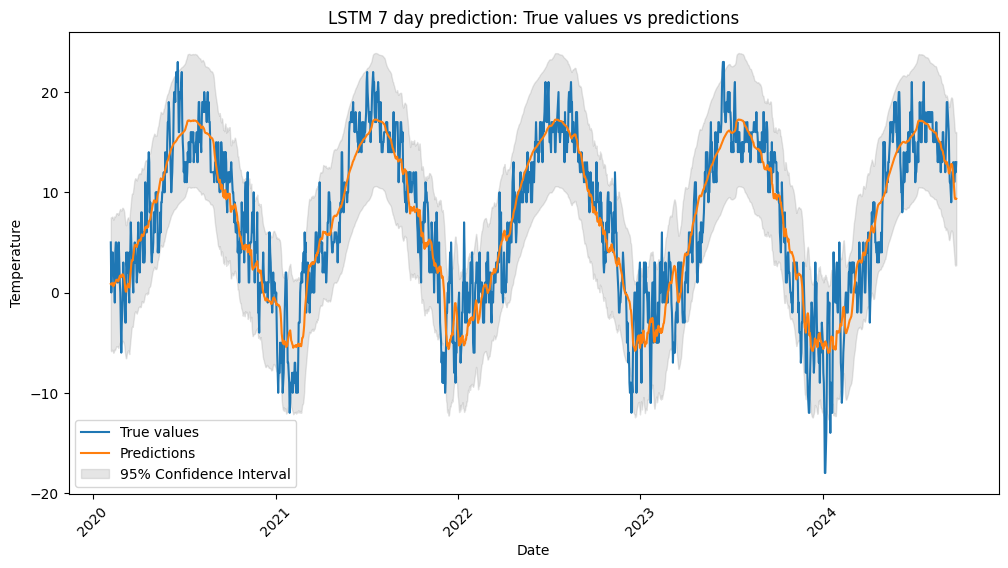

LSTM 7 day MAE: 2.684819197418701
LSTM 7 day MSE: 11.490392786122595
LSTM 7 day RMSE: 3.3897481891908425
LSTM 7 day percentage within confidence interval: 94.56264775413712%
LSTM 7 day percentage within margin of error: 23.52245862884161%


In [7]:
lstm_7day_mae, lstm_7day_mse, lstm_7day_rmse, lstm_seven_day_within_interval, lstm_seven_day_within_margin = calculate_metrics_and_plot(predictions, y_test, test_date_output, 7)
print(f"LSTM 7 day MAE: {lstm_7day_mae}")
print(f"LSTM 7 day MSE: {lstm_7day_mse}")
print(f"LSTM 7 day RMSE: {lstm_7day_rmse}")
print(f"LSTM 7 day percentage within confidence interval: {lstm_seven_day_within_interval}%")
print(f"LSTM 7 day percentage within margin of error: {lstm_seven_day_within_margin}%")

# 30 Day prediction

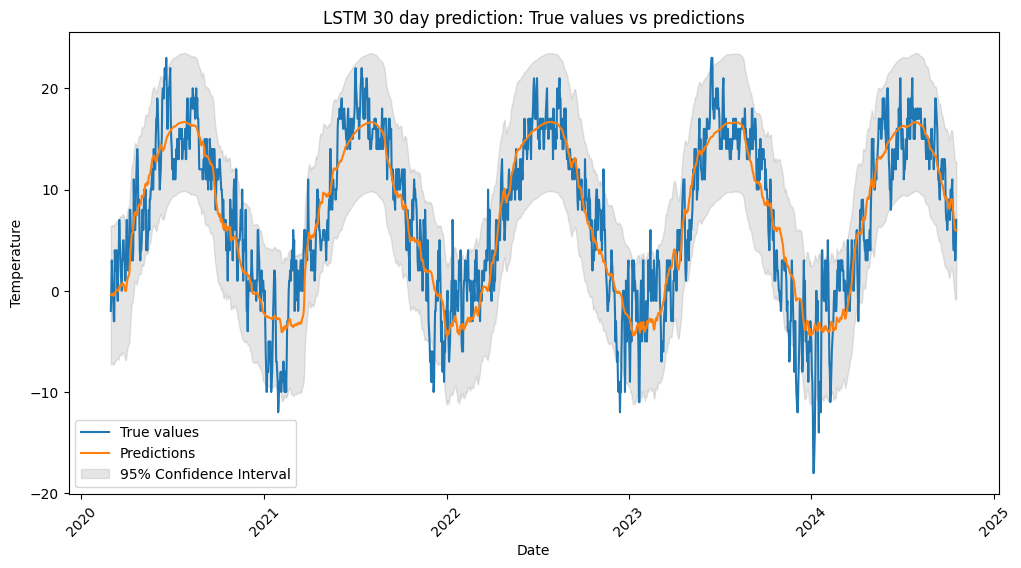

LSTM 30 day MAE: 2.7543857998476664
LSTM 30 day MSE: 12.113641393235307
LSTM 30 day RMSE: 3.480465686260289
LSTM 30 day percentage within confidence interval: 95.39007092198581%
LSTM 30 day percentage within margin of error: 22.81323877068558%


In [8]:
lstm_30day_mae, lstm_30day_mse, lstm_30day_rmse, lstm_thirty_day_within_interval, lstm_thirty_day_within_margin = calculate_metrics_and_plot(predictions, y_test, test_date_output, 30)
print(f"LSTM 30 day MAE: {lstm_30day_mae}")
print(f"LSTM 30 day MSE: {lstm_30day_mse}")
print(f"LSTM 30 day RMSE: {lstm_30day_rmse}")
print(f"LSTM 30 day percentage within confidence interval: {lstm_thirty_day_within_interval}%")
print(f"LSTM 30 day percentage within margin of error: {lstm_thirty_day_within_margin}%")

In [9]:
spark.stop()